# Predicting NBA Playoff Teams at the Trade Deadline

## 1. Problem Statement
Every February, NBA players, coaches, and executives take a much-needed break from the grueling NBA season during the annual All Star Break. The All Star Break (ASB) also marks an important date in the NBA calendar: the in-season Trade Deadline. Executives need to decide if they are "buyers" or "sellers" in the trade market and make difficult decisions about short-term and long-term assets in the form of players and draft capital. To this end, I'll attempt to predict whether a given NBA taem will make the playoffs.

A major factor in a GM's decision-making process before the All Star Break is whether or not they expect their team to make the Playoffs in April. If the team has a good chance to make the Playoffs, a GM is more likely to keep strong players on their team. If the team is unlikely to make the Playoffs, it would make more sense to consider trading a strong player for picks in the upcoming draft.

*What Does Success Look Like?* <br>
Personnel decisions are very sensitive, so in order for my model to be useful, I need to be able to predict with a high-level of accuracy (> 80% accuracy in a classification model) whether or not a team will make the playoffs. 

## 2. Approach Overview

#### 2.1 Data Source
I was able to source a high-quality data set containg NBA teams, players, and statistics from the 2012 NBA season through the 2018 NBA season: https://www.kaggle.com/pablote/nba-enhanced-stats

#### 2.2 Target Variables
For the Classification model, my target variable will be a binary "True/False" for whether or not a given team makes the playoffs in a given year.

For the Regression model, my target variable will be each team's exact end of season ranking.

#### 2.3 Feature Variables
This NBA dataset includes daily, in-season statistics for each team ranging from the team's standing in the rankings, in-game statistics, and strength of remaining schedule.

#### 2.4 Model Approach
For the Classification model, I will assess the accuracy, bias, and variance of a Logistic Regression Model as well as a Random Forest Classification model and determine the best model for my use case accordingly.

For the Regression model, I will assess the accuracy, bias, and variance of a Linear Regression Model as well as a Random Forest Regression model and determine the best model for my use case accordingly.

## 3. Data Preparation

### 3.1 Loading Libraries and Data

In [1]:
# Import standard notebook libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
%matplotlib inline

#Import sklearn modeling libraries
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
#Import the data from CSV
nba_path = "../nba-enhanced-stats/2012-18_standings.csv"
nba = pd.read_csv(nba_path)

### 3.2 Transforming Data

In [3]:
#I will now transform my data so that each row contains team data from the last day 
#in the regular season before the ASB each year as well as their end-of-season ranking
nba['year'] = pd.DatetimeIndex(nba['stDate']).year
nba['month'] = pd.DatetimeIndex(nba['stDate']).month

#Splitting the data into ASB and Playoffs
relevant_months = nba.loc[:,"month"].isin([2,4])
nba = nba.loc[relevant_months,:]
february = nba.loc[:,"month"] == 2
asb = nba.loc[february,:]
april = nba.loc[:,"month"] == 4
playoffs = nba.loc[april,:]

#Specifying ASB dates
last_game_played_dates = ["2013-02-14","2014-02-13","2015-02-11","2016-02-11","2017-02-16","2018-02-15"]
cond = asb.loc[:,str("stDate")].isin(last_game_played_dates)
asb = asb.loc[cond,:]

#Specifying Playoffs dates
playoff_dates = ["2013-04-17","2014-04-16","2015-04-15","2016-04-13","2017-04-12","2018-04-11"]
cond = playoffs.loc[:,"stDate"].isin(playoff_dates)
playoffs = playoffs.loc[cond,:]
playoffs = playoffs.loc[:,["teamAbbr","year","rank"]]

#Joining the data back into a single DF
nba = asb.merge(playoffs,on=["teamAbbr","year"],how="inner")

### 3.3 Engineering Feature Variable

In [5]:
#Split teams into Eastern and Western conferences
cond = nba.loc[:,"teamAbbr"].isin(["ATL","BKN","BOS","CHA","CHI","CLE","DET","IND","MIA","MIL","NY","ORL","PHI","TOR","WAS"])
east = nba.loc[cond,:]
west = nba.loc[~cond,:]

#Find the playoff_cutoff for each year in each conference each year at ASB
east.loc[east.loc[:,"rank_x"].isin([7,8])].groupby("year").agg({"gameBack":"max"})
west.loc[west.loc[:,"rank_x"].isin([7,8])].groupby("year").agg({"gameBack":"max"})

#Add playoff_cutoff to each dataset
east.loc[east.loc[:,"year"] == 2013,"playoff_cutoff"] = 10.5
east.loc[east.loc[:,"year"] == 2014,"playoff_cutoff"] = 17.5
east.loc[east.loc[:,"year"] == 2015,"playoff_cutoff"] = 20.0
east.loc[east.loc[:,"year"] == 2016,"playoff_cutoff"] = 11.5
east.loc[east.loc[:,"year"] == 2017,"playoff_cutoff"] = 13.0
east.loc[east.loc[:,"year"] == 2018,"playoff_cutoff"] = 11.5

#Add playoff_cutoff to each dataset
west.loc[west.loc[:,"year"] == 2013,"playoff_cutoff"] = 13.5
west.loc[west.loc[:,"year"] == 2014,"playoff_cutoff"] = 11.0
west.loc[west.loc[:,"year"] == 2015,"playoff_cutoff"] = 14.5
west.loc[west.loc[:,"year"] == 2016,"playoff_cutoff"] = 22.0
west.loc[west.loc[:,"year"] == 2017,"playoff_cutoff"] = 22.0
west.loc[west.loc[:,"year"] == 2018,"playoff_cutoff"] = 13.0

#Join conferences back together
nba = pd.concat([east,west])

#Calculate each team's standing relative to the playoff_cutoff in their conference each year
def calc_relativeGB(row):
    return row.loc["gameBack"] - row.loc["playoff_cutoff"]

nba.loc[:,"relativeGB"] = nba.apply(calc_relativeGB,axis="columns")
nba;

### 3.4 Engineering Target Variable

In [33]:
#Add boolean target_col for make_playoffs
cond = nba.loc[:,"rank_y"] <= 8
nba.loc[:,"make_playoffs"] = cond
nba.loc[:,"make_playoffs"] = nba.loc[:,"make_playoffs"].astype(int)

### 3.5 Create Short and Long Versions of Data

In [34]:
#Store a copy of the full data set with all columns
nba_long = nba

#Create an abridged data set with columns selected for interpretability/usefulness
abridged_cols = ["stDate","teamAbbr","rank_x","gameBack","relativeGB","lastFive","lastTen","ptsDiff","sos","rank_y","make_playoffs"]
nba_short = nba.loc[:,abridged_cols]

### 3.6 Summary of Clean Dataset

In [35]:
#Data preview
nba_short.head()

,stDate,teamAbbr,rank_x,gameBack,relativeGB,lastFive,lastTen,ptsDiff,sos,rank_y,make_playoffs
0,2013-02-14,ATL,6,7.5,-3.0,3,6,0.8,0.4879,6,1
1,2013-02-14,BKN,4,6.5,-4.0,3,5,0.5,0.5025,4,1
2,2013-02-14,BOS,7,9.0,-1.5,4,8,0.0,0.4976,7,1
3,2013-02-14,CHA,15,25.0,14.5,1,2,-8.9,0.4984,14,0
4,2013-02-14,CHI,5,7.0,-3.5,1,4,1.6,0.4954,5,1


In [36]:
#Data shape
nba_short.shape

(180, 11)

In [37]:
#Columns
nba_short.columns

Index(['stDate', 'teamAbbr', 'rank_x', 'gameBack', 'relativeGB', 'lastFive',
       'lastTen', 'ptsDiff', 'sos', 'rank_y', 'make_playoffs'],
      dtype='object')

In [38]:
#Summary statistics (no null values!)
nba_short.describe()

,rank_x,gameBack,relativeGB,lastFive,lastTen,ptsDiff,sos,rank_y,make_playoffs
count,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000
mean,7.916667,15.041667,0.041667,2.466667,4.994444,0.000556,0.499876,7.844444,0.550000
std,4.338827,8.748164,8.515821,1.317692,2.133786,4.755949,0.009644,4.407741,0.498881
min,1.000000,0.000000,-22.000000,0.000000,0.000000,-10.700000,0.476900,1.000000,0.000000
25%,4.000000,8.500000,-5.500000,1.750000,4.000000,-3.000000,0.493575,4.000000,0.000000
50%,8.000000,14.500000,0.000000,3.000000,5.000000,-0.200000,0.499450,8.000000,1.000000
75%,12.000000,22.000000,6.000000,3.000000,6.250000,3.125000,0.505500,12.000000,1.000000
max,15.000000,38.500000,19.000000,5.000000,10.000000,13.300000,0.526300,15.000000,1.000000


## 4. Exploratory Data Analysis

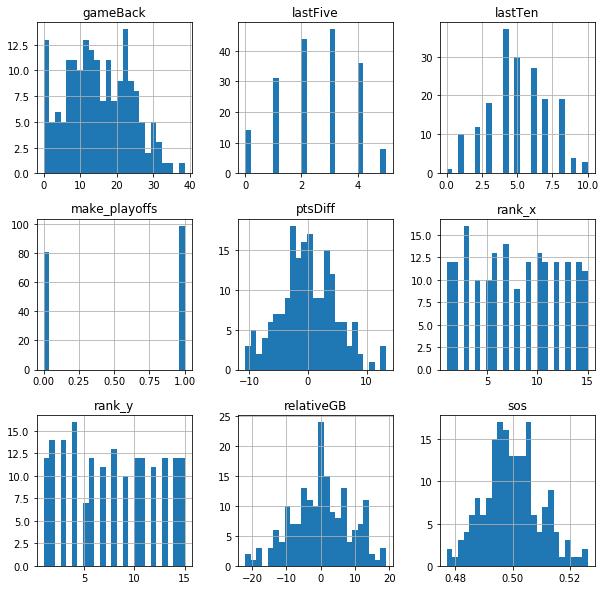

In [39]:
# Visualize distributions of each column
ax = nba_short.hist(figsize=(10,10), bins = 25)

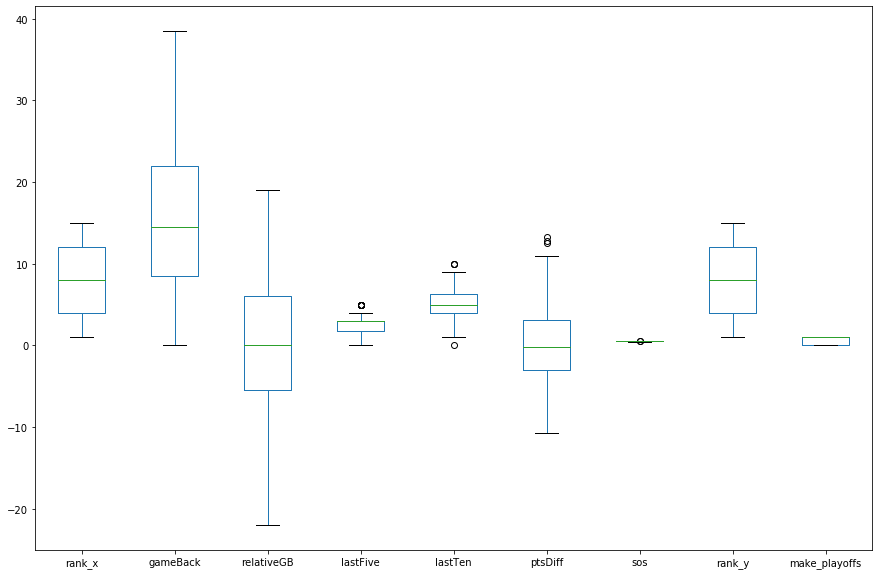

In [40]:
#Boxplot to visualize the data and identify outliers.
ax = nba_short.plot(kind='box', figsize=(15, 10))

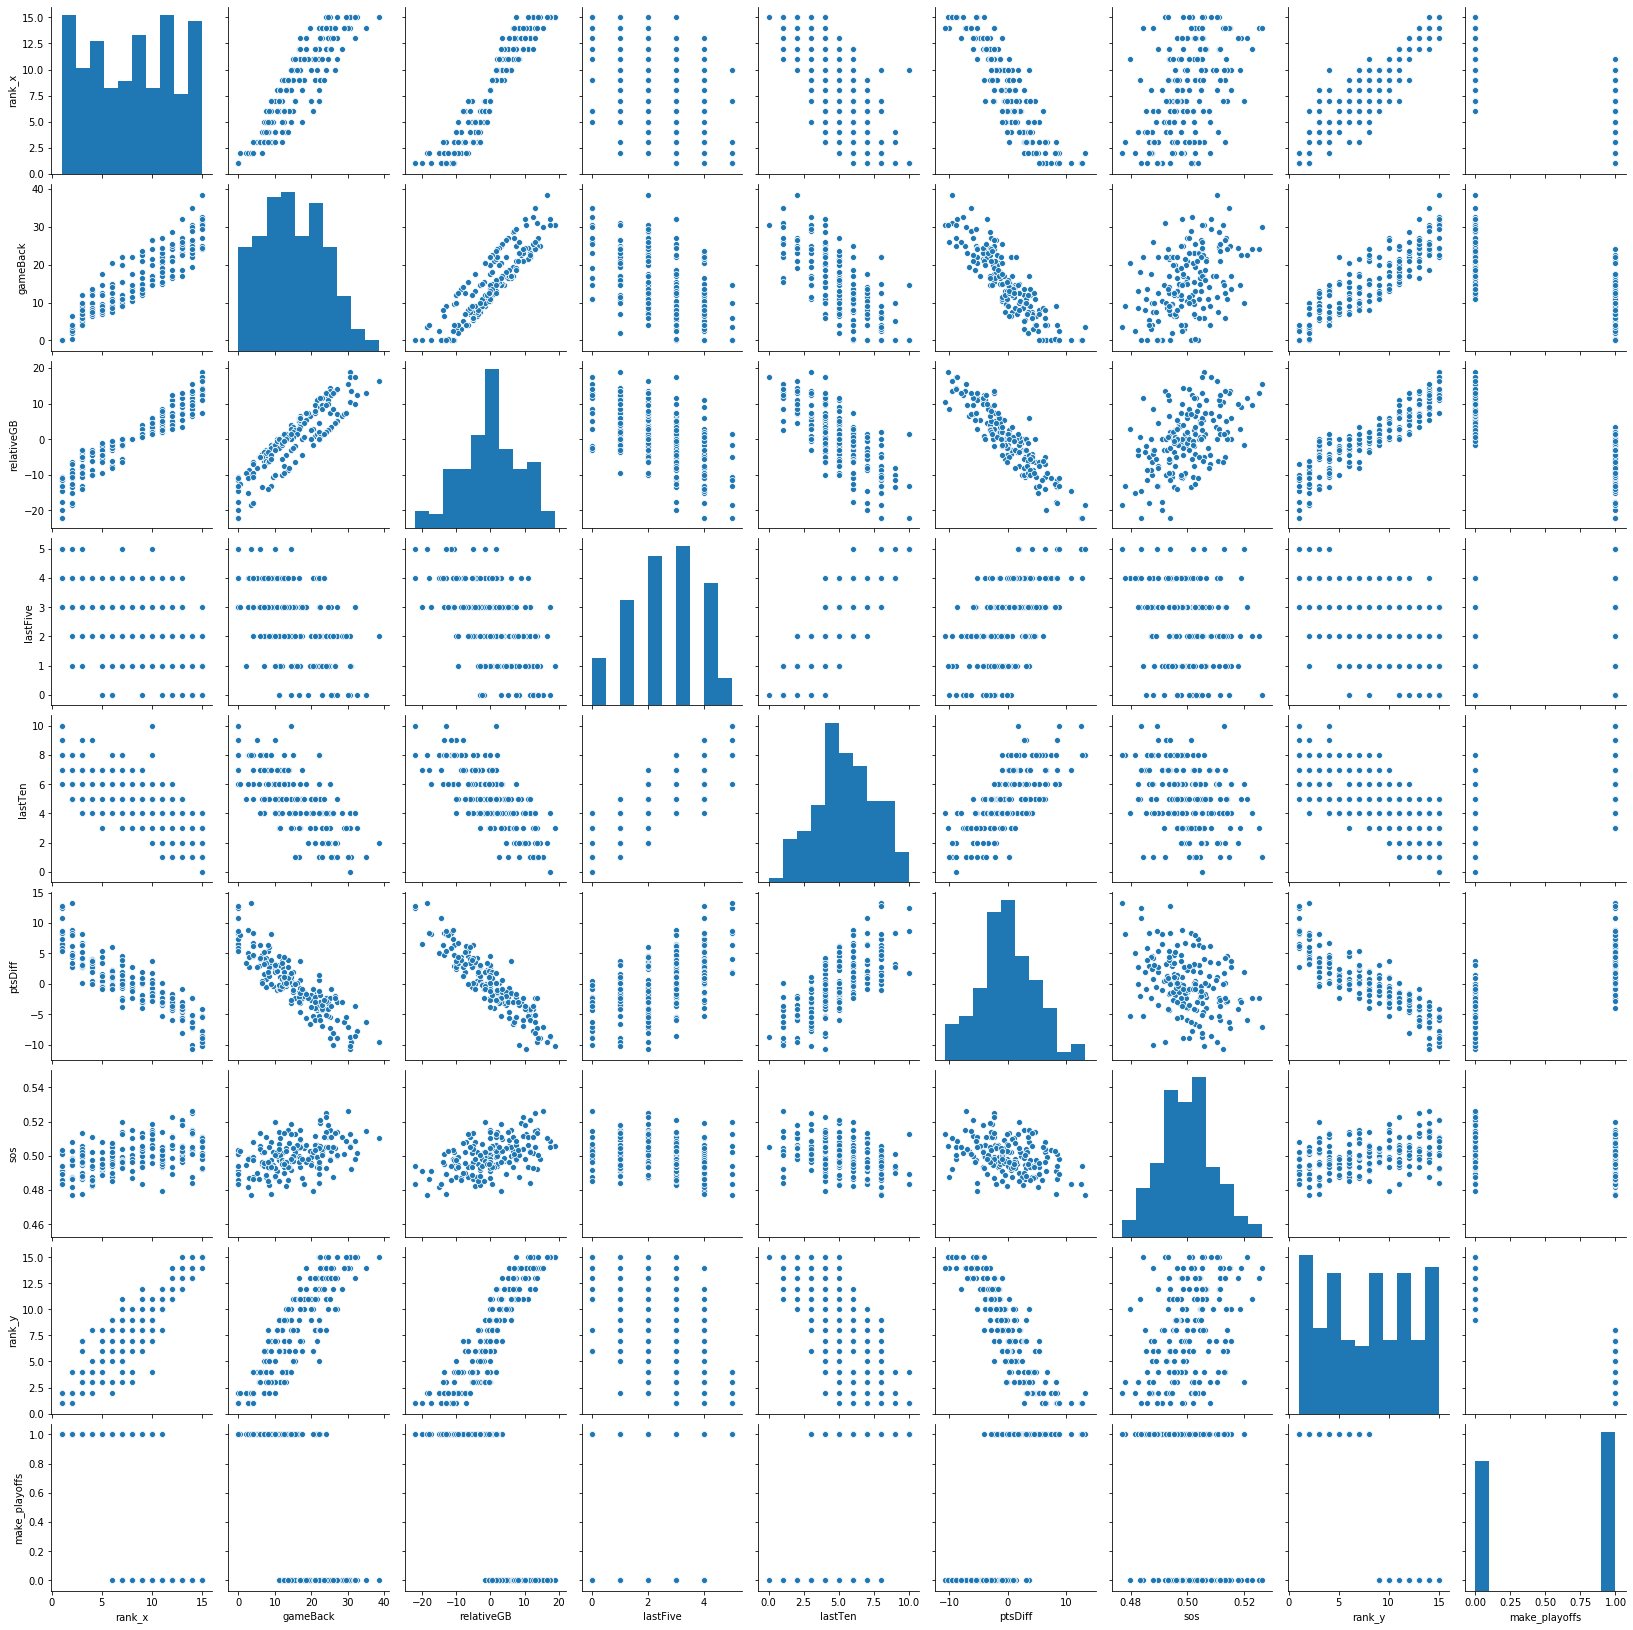

In [41]:
#Scatter matrix to view relationships between variables
g = sns.pairplot(nba_short)

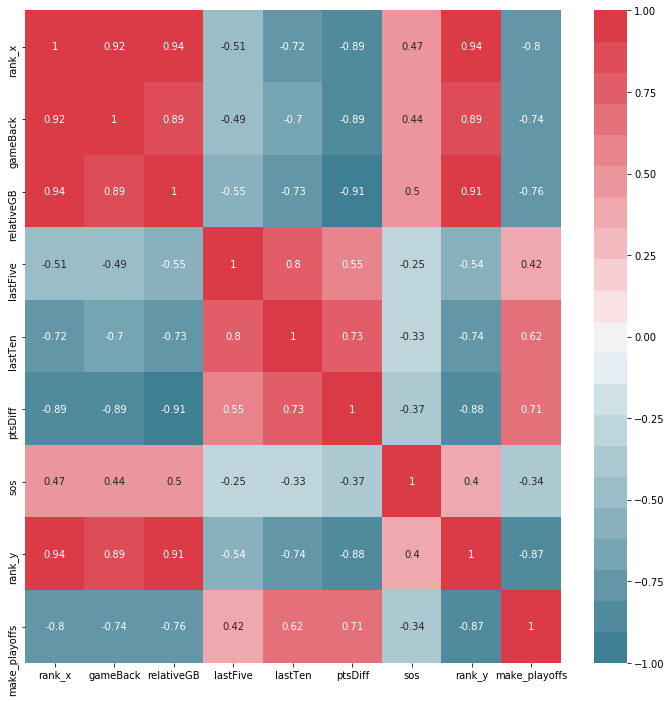

In [42]:
#Heatmap to see correlation of variables
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(nba_short.corr(),
            vmin=-1,
            vmax=1,
            cmap=sns.diverging_palette(220, 10, n=21),
            annot=True,
            ax=ax,
           );

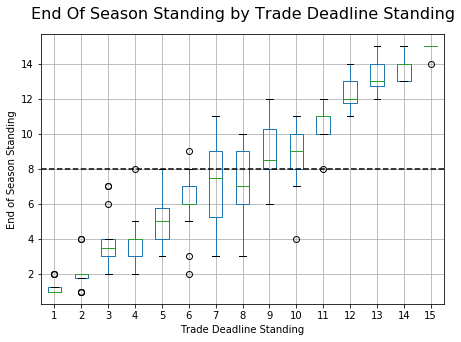

In [43]:
#Let's visualize some box_plots for features which are highly correlated with rank_y
#Starting with rank_x
ax = nba_short.boxplot(
    "rank_y",
    by="rank_x", 
    figsize=(7,5));
ax.set_title("End Of Season Standing by Trade Deadline Standing", fontsize= 16, pad=15)
ax.axhline(8, color='k', linestyle='--')
plt.ylabel("End of Season Standing")
plt.xlabel("Trade Deadline Standing")
plt.suptitle('');

*Observation:* <br>
It's very uncommon for teams with a high standing(rank_x = 1-4) at the Trade Deadline to fall below the playoff cutoff by the end of the season (rank_y = 8). Middle seeds (rank_x = 6-9) have the highest variance in rank_y. Low ranked teams (rank_x >10) at the Trade Deadline don't have much variance and are usually still low in the rankings at the end of hte season.

The middle seeded teams are the most likely to be in need of a playoff prediction model as the high and low-seeded teams already know with a reasonable level of certainty whether or not they will make the playoffs given their ASB standing.

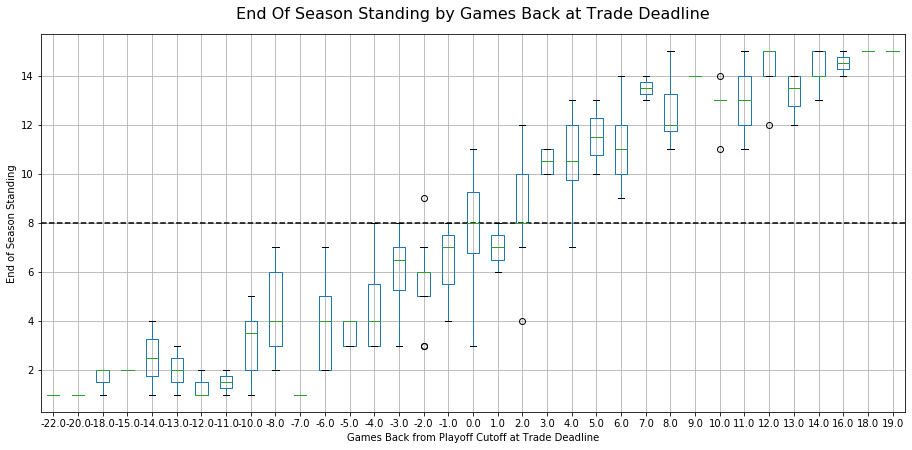

In [44]:
#Now, let's look at a team's standing relative to the playoff_cutoff
nba_short.loc[:,"roundGB"] = nba_short.loc[:,"relativeGB"].round(0)

ax = nba_short.boxplot(
    "rank_y",
    by="roundGB", 
    figsize=(15,7));
ax.set_title("End Of Season Standing by Games Back at Trade Deadline", fontsize= 16, pad=15)
ax.axhline(8, color='k', linestyle='--')
plt.ylabel("End of Season Standing")
plt.xlabel("Games Back from Playoff Cutoff at Trade Deadline")
plt.suptitle('');

*Observation:* <br>
Teams who are on the "bubble" at the Trade Season Deadline (relativeGB = 0) have high variance and may break into the playoffs or drop out of the playoffs. Interestingly, there isn't a great deal of variance for teams who are even slightly above (or below) the playoff cutoff which may mean that it'll be difficult to predict a team that will drop from above to below or vice versa as it's uncommon.

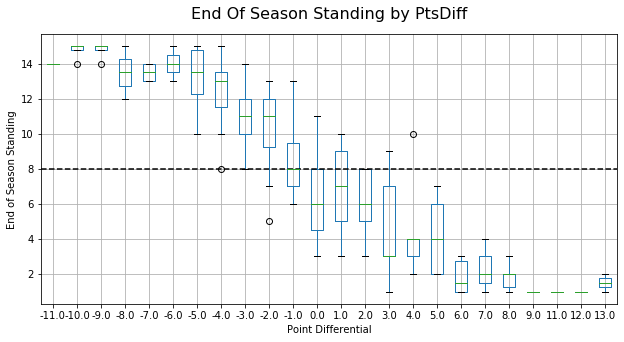

In [45]:
nba_short.loc[:,"roundPtsDiff"] = nba_short.loc[:,"ptsDiff"].round(0)
nba_short_2 = nba_short.loc[::-1]

ax = nba_short_2.boxplot(
    "rank_y",
    by="roundPtsDiff", 
    figsize=(10,5));
ax.set_title("End Of Season Standing by PtsDiff", fontsize= 16, pad=15)
ax.axhline(8, color='k', linestyle='--')
plt.ylabel("End of Season Standing")
plt.xlabel("Point Differential")
plt.suptitle('');

*Observation:* <br>
Teams with a a high point differential are more likely to winning more games and thus earning high rankings and making the playoffs.

Point differential may be a good way of identifying "unlucky" teams whose standing at the Trade Deadline are lower than their expected standing given their point differential.

In [46]:
#Clean up columns from visualization
nba_short = nba_short.drop(columns=["roundPtsDiff","roundGB"])

## 5. Classification Model

### 5.1 Classification Baseline

In [48]:
#Let's define a null-model baseline for a classification model predicting make_playoffs

nba_short.loc[:,"make_playoffs"].value_counts(normalize=True)

1    0.55
0    0.45
Name: make_playoffs, dtype: float64

In [49]:
#Now, let's define a more rigorous baseline based on ASB standings
#What's the baseline if you predict that all teams at or above the playoff_cutoff
#at the trade deadline will maintain their standing through the end of the season?

cond = nba_short.loc[:,"rank_x"] <= 8
nba.loc[cond,"make_playoffs"].value_counts(normalize=True)

1    0.895833
0    0.104167
Name: make_playoffs, dtype: float64

### 5.2 Define Samples

In [50]:
target_col = "make_playoffs"

X = nba_short.drop(columns = ["stDate","teamAbbr","rank_y","make_playoffs"])
y = nba_short.loc[:,target_col]

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=2)

### 5.3 Logistic Regression Classification

In [51]:
#Let's create an initial Logistic Regression model to predict make_playoffs
nba_grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=1_000),
    param_grid={},
    cv = KFold(n_splits=3, shuffle=True, random_state=3),
    return_train_score=True
)

nba_grid.fit(X,y)
pd.DataFrame(nba_grid.cv_results_).loc[:, ["mean_train_score", "mean_test_score"]]

,mean_train_score,mean_test_score
0,0.922222,0.861111


In [52]:
#Now, let's try scaling the features to improve predictive performance
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline(steps=[('scaler', StandardScaler()), ('lr',LogisticRegression(max_iter=10_000))])

scaler = StandardScaler()
scaler.fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)

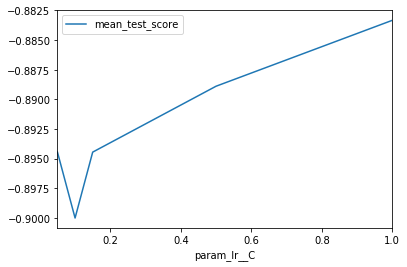

In [54]:
#And tune regularization using the C hyperparameter
nba_grid = GridSearchCV(
    estimator=pipe,
    param_grid={"lr__C":[0.05,0.1,0.15,0.5,1.0]},
    cv = KFold(n_splits=5, shuffle=True, random_state=3),
    return_train_score=True
)

nba_grid.fit(X,y)

scores = -(
    pd.DataFrame(nba_grid.cv_results_)
  .loc[:,["param_lr__C","mean_test_score"]]
  .set_index("param_lr__C")
)

scores

ax=scores.plot()

In [55]:
lr = nba_grid.best_estimator_

In [62]:
#Does this tuned model have improved predictive accuracy?
final_grid = GridSearchCV(
    estimator=lr,
    param_grid={},
    cv = KFold(n_splits=10, shuffle=True, random_state=3),
    return_train_score=True
)

final_grid.fit(X,y)
pd.DataFrame(final_grid.cv_results_).loc[:, ["mean_train_score", "mean_test_score"]]

,mean_train_score,mean_test_score
0,0.904938,0.9


In [73]:
#Here's my final model
lr_final = final_grid.best_estimator_
lr_final;

In [74]:
#What's the feature importance for a model like the one above?
lr_simple = LogisticRegression(C=0.1)
lr_simple.fit(X_train,y_train)
pd.DataFrame(
    {"feature": X.columns,"coefficient": abs(lr_simple.coef_[0])}
).sort_values("coefficient",ascending=False)

,feature,coefficient
2,relativeGB,0.484490
5,ptsDiff,0.154497
4,lastTen,0.079312
3,lastFive,0.050791
1,gameBack,0.019596
6,sos,0.002414
0,rank_x,0.002115


*Decision Tree Classification Summary:* <br>

By scaling the features and tuning regularization with the C hyperparameter, I've been able to ever so marginally improve the model accuracy performance (0.9) above the baseline (0.895833) though this difference is insignificant given the problem statement and use case.

### 5.2 Decision Tree Classification

In [75]:
#Let's create an initial Decision Tree Classifier model to predict make_playoffs
nba_grid = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid={},
    cv = KFold(n_splits=3, shuffle=True, random_state=3),
    return_train_score=True
)

nba_grid.fit(X,y)
pd.DataFrame(nba_grid.cv_results_).loc[:, ["mean_train_score", "mean_test_score"]]

,mean_train_score,mean_test_score
0,1.0,0.816667


*Decision Tree Classification Summary:* <br>

Given the better out-of-the-box performance of Logistic Regression and Random Forest Classification, I'll focus my efforts on attempting to tune those models rather than explore this option further.

### 5.3 Random Forest Classification

In [61]:
#Now let's create an initial Random Forest Classification model to predict make_playoffs
nba_grid = GridSearchCV(
    estimator=RandomForestClassifier(n_estimators=200),
    param_grid={},
    cv = KFold(n_splits=3, shuffle=True, random_state=3),
    return_train_score=True
)

nba_grid.fit(X,y)
pd.DataFrame(nba_grid.cv_results_).loc[:, ["mean_train_score", "mean_test_score"]]

,mean_train_score,mean_test_score
0,1.0,0.861111


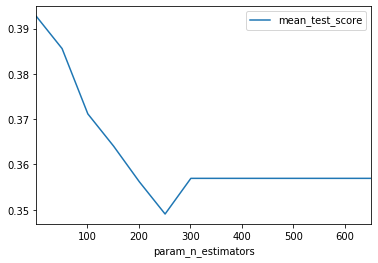

In [64]:
#Tune for n_estimators
grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=1),
    param_grid={"n_estimators": range(1,701,50)},
    cv=KFold(n_splits=5,shuffle=True,random_state=1),
    return_train_score=True,
    scoring="neg_root_mean_squared_error",
)

grid.fit(X,y)

scores = -(
    pd.DataFrame(grid.cv_results_)
  .loc[:,["param_n_estimators","mean_test_score"]]
  .set_index("param_n_estimators")
)

ax=scores.plot()

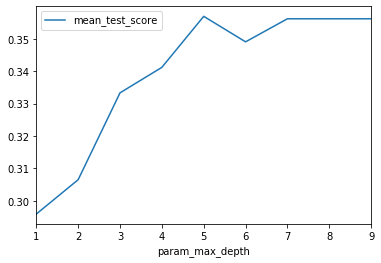

In [65]:
#Tune for max_depth
grid = GridSearchCV(
    estimator=RandomForestClassifier(n_estimators=250,random_state=1),
    param_grid={"max_depth": range(1,10)},
    cv=KFold(n_splits=5,shuffle=True,random_state=1),
    return_train_score=True,
    scoring="neg_root_mean_squared_error",
)

grid.fit(X,y)

scores = -(
    pd.DataFrame(grid.cv_results_)
  .loc[:,["param_max_depth","mean_test_score"]]
  .set_index("param_max_depth")
)

ax=scores.plot()

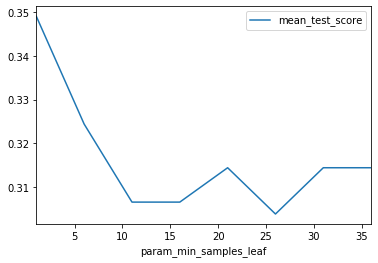

In [66]:
#Tune for min_samples_leaf
grid = GridSearchCV(
    estimator=RandomForestClassifier(n_estimators=50,max_depth=5,random_state=1),
    param_grid={"min_samples_leaf": range(1,40,5)},
    cv=KFold(n_splits=5,shuffle=True,random_state=1),
    return_train_score=True,
    scoring="neg_root_mean_squared_error",
)

grid.fit(X,y)

scores = -(
    pd.DataFrame(grid.cv_results_)
  .loc[:,["param_min_samples_leaf","mean_test_score"]]
  .set_index("param_min_samples_leaf")
)

ax=scores.plot()

In [68]:
#Grab the best min_samples_leaf param
grid.best_score_,grid.best_params_

(-0.30381277183368793, {'min_samples_leaf': 26})

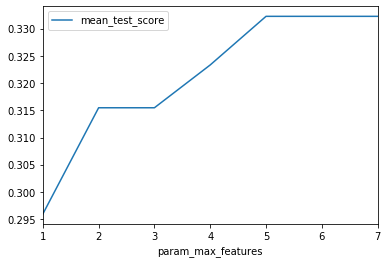

In [69]:
#Tune for max_features
grid = GridSearchCV(
    estimator=RandomForestClassifier(n_estimators=250,max_depth=5,min_samples_leaf=10,random_state=1),
    param_grid={"max_features": range(1,(len(X.columns)+1))},
    cv=KFold(n_splits=5,shuffle=True,random_state=1),
    return_train_score=True,
    scoring="neg_root_mean_squared_error",
)

grid.fit(X,y)

scores = -(
    pd.DataFrame(grid.cv_results_)
  .loc[:,["param_max_features","mean_test_score"]]
  .set_index("param_max_features")
)

ax=scores.plot()

In [70]:
#Now let's see if this tuning improves predictive accuracy
final_grid = GridSearchCV(
    estimator=RandomForestClassifier(n_estimators=250,max_depth=5,min_samples_leaf=10,random_state=1),
    param_grid={},
    cv=KFold(n_splits=10,shuffle=True,random_state=1),
    return_train_score=True,
)

final_grid.fit(X,y)
pd.DataFrame(final_grid.cv_results_).loc[:, ["mean_train_score", "mean_test_score"]]

,mean_train_score,mean_test_score
0,0.910494,0.9


In [77]:
#Here's my final model
rfc = final_grid.best_estimator_

In [78]:
#What's the feature importance for this model?
pd.DataFrame(
    {"feature": X.columns,"importance": rfc.feature_importances_}
).sort_values("importance",ascending=False)

,feature,importance
2,relativeGB,0.338287
5,ptsDiff,0.220161
1,gameBack,0.198102
0,rank_x,0.174627
4,lastTen,0.047857
3,lastFive,0.010874
6,sos,0.010090


*Random Forest Classification Summary:* <br>

By tuning the above hyperparameters, I've been able to ever so marginally improve the model accuracy performance (0.9) above the baseline (0.895833) though this difference is insignificant given the problem statement and use case.

## 7. Summary + Next Steps

### 7.1 Summary

-The best baseline is if a team’s standing is <= 8 at the Trade Deadline then predict that a team will make the Playoffs (accuracy of 0.89%).

-After experimenting with multiple classification models, even the best model (Logistic Regression in this case) didn't significantly outperform this baseline.

-Using such a baseline also provides a highly interpretable model for a non-technical GM responsible for making personnel decisions.


### 7.3 Opportunities and Next Steps

To continue forward in this effort, I would recommend purusing the following opportunities:
- More advanced techniques for reducing variance in Random Forest Classification models
- Other Classification models
- Try a Regression model which predicts rank_y and predict make_playoffs based on that model's prediction